In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import math
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso


import warnings
warnings.filterwarnings("ignore")

# 1. Exploration et nettoyage des données

In [2]:
idf_dvf = pd.read_csv("idf_dvf.csv",low_memory=False)
print(idf_dvf.shape)
idf_dvf.head()

(2311621, 41)


,Unnamed: 0,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2313486,2019-966415,2019-01-03,1,Vente,310000.0,11.0,NaN,RUE DE LA FONTAINE,0650,...,Maison,101.0,4.0,S,sols,NaN,NaN,323.0,2.740574,48.739669
1,2313487,2019-966415,2019-01-03,1,Vente,310000.0,NaN,NaN,GRETZ,B018,...,NaN,NaN,NaN,J,jardins,POTAG,Jardin potager,532.0,2.741131,48.739847
2,2313488,2019-966416,2019-01-03,1,Vente,150000.0,1491.0,NaN,AV DE LA GARE,0390,...,Maison,72.0,3.0,AG,terrains d'agrément,PARC,Parc,1407.0,2.539824,48.563586
3,2313489,2019-966416,2019-01-03,1,Vente,150000.0,1491.0,NaN,AV DE LA GARE,0390,...,Maison,72.0,3.0,S,sols,NaN,NaN,86.0,2.539824,48.563586
4,2313490,2019-966417,2019-01-09,1,Vente,250000.0,14.0,NaN,RUE ST AMBROISE,1510,...,Local industriel. commercial ou assimilé,44.0,0.0,NaN,NaN,NaN,NaN,NaN,2.656724,48.534489


In [3]:
idf_dvf.info(null_counts=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311621 entries, 0 to 2311620
Data columns (total 41 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   Unnamed: 0                    2311621 non-null  int64  
 1   id_mutation                   2311621 non-null  object 
 2   date_mutation                 2311621 non-null  object 
 3   numero_disposition            2311621 non-null  int64  
 4   nature_mutation               2311621 non-null  object 
 5   valeur_fonciere               2293357 non-null  float64
 6   adresse_numero                1969280 non-null  float64
 7   adresse_suffixe               132725 non-null   object 
 8   adresse_nom_voie              2261624 non-null  object 
 9   adresse_code_voie             2262446 non-null  object 
 10  code_postal                   2261616 non-null  float64
 11  code_commune                  2311621 non-null  int64  
 12  nom_commune                 

On constitue un dataframe avec les variables nécessaires pour notre analyse de données,puis on supprime les valeurs nulle. On change le type des variable 'code_type_local','code_commune','adresse_code_voie' en chaine de caractère.

In [4]:
data = idf_dvf[['id_mutation','date_mutation','numero_disposition','nature_mutation','valeur_fonciere',
                'adresse_nom_voie','adresse_code_voie','code_commune','nom_commune',
                'code_departement','id_parcelle','nombre_lots','code_type_local','type_local',
                'nombre_pieces_principales','surface_reelle_bati']].dropna()

data[['code_type_local','code_commune','adresse_code_voie']] = data[['code_type_local','code_commune','adresse_code_voie']].astype('str')
print(type(data['code_type_local'][0]))
# Création des intervals sur la variable surface_reelle_bati
intervalIndex = pd.interval_range(start=0, end=100000, freq=10)
surface_range = pd.cut(data['surface_reelle_bati'],bins=intervalIndex).astype('str')
data['interval_surface'] = surface_range
print(len(data['interval_surface'].unique()))
data.head()

<class 'str'>
1197


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_nom_voie,adresse_code_voie,code_commune,nom_commune,code_departement,id_parcelle,nombre_lots,code_type_local,type_local,nombre_pieces_principales,surface_reelle_bati,interval_surface
0,2019-966415,2019-01-03,1,Vente,310000.0,RUE DE LA FONTAINE,0650,77215,Gretz-Armainvilliers,77,772150000B0473,0,1.0,Maison,4.0,101.0,"(100.0, 110.0]"
2,2019-966416,2019-01-03,1,Vente,150000.0,AV DE LA GARE,0390,77407,Saint-Fargeau-Ponthierry,77,77407000AD0345,0,1.0,Maison,3.0,72.0,"(70.0, 80.0]"
3,2019-966416,2019-01-03,1,Vente,150000.0,AV DE LA GARE,0390,77407,Saint-Fargeau-Ponthierry,77,77407000AD0345,0,1.0,Maison,3.0,72.0,"(70.0, 80.0]"
4,2019-966417,2019-01-09,1,Vente,250000.0,RUE ST AMBROISE,1510,77288,Melun,77,77288000AV0266,2,4.0,Local industriel. commercial ou assimilé,0.0,44.0,"(40.0, 50.0]"
6,2019-966418,2019-01-04,1,Vente,155000.0,AV DE LA GARE,0600,77373,Pontault-Combault,77,77373000AD0157,1,2.0,Appartement,2.0,51.0,"(50.0, 60.0]"


In [5]:
print("nom_commune unique : ",len(data['nom_commune'].unique()))
print("code_commune unique : ",len(data['code_commune'].unique()))
print("")
print("type_local unique : ",len(data['type_local'].unique()))
print("code_type_local unique : ",len(data['code_type_local'].unique()))


nom_commune unique :  1282
code_commune unique :  1286

type_local unique :  4
code_type_local unique :  4


## Déscription des variables numériques

In [6]:
data.drop(columns=['numero_disposition','id_parcelle','code_departement']).describe(percentiles=[.01,.25, .5, .75, .95, .99]).apply(lambda s: s.apply('{0:.5f}'.format))
#
#

,valeur_fonciere,nombre_lots,nombre_pieces_principales,surface_reelle_bati
count,1230654.00000,1230654.00000,1230654.00000,1230654.00000
mean,5160278.22119,1.00968,2.84002,98.49486
std,29117408.41169,1.64347,1.72664,644.78972
min,0.11000,0.00000,0.00000,1.00000
1%,10000.00000,0.00000,0.00000,10.00000
25%,188000.00000,0.00000,2.00000,40.00000
50%,300000.00000,1.00000,3.00000,63.00000
75%,633000.00000,2.00000,4.00000,88.00000
95%,18150000.00000,2.00000,6.00000,168.00000
99%,132735744.00000,4.00000,7.00000,629.00000


## Élimination des valeur abérante

In [7]:
data = data[~((data.surface_reelle_bati < 100) & (data.valeur_fonciere > 100000000))]
data = data[(data.surface_reelle_bati > 8) & (data.valeur_fonciere > 10000) ]
data[['valeur_fonciere','nombre_lots','nombre_pieces_principales','surface_reelle_bati']].describe(percentiles=[.01,.25, .5, .75, .95, .99]).apply(lambda s: s.apply('{0:.5f}'.format))
#
#

,valeur_fonciere,nombre_lots,nombre_pieces_principales,surface_reelle_bati
count,1200178.00000,1200178.00000,1200178.00000,1200178.00000
mean,2962034.85409,1.02062,2.86122,98.45458
std,12873106.86863,1.65481,1.72574,642.51312
min,10001.00000,0.00000,0.00000,9.00000
1%,53000.00000,0.00000,0.00000,11.00000
25%,190000.00000,0.00000,2.00000,40.00000
50%,300000.00000,1.00000,3.00000,63.00000
75%,615000.00000,2.00000,4.00000,88.00000
95%,13826074.00000,2.00000,6.00000,169.00000
99%,66975936.00000,4.00000,7.00000,618.00000


In [8]:
print('Variable nature_mutation\n\n',data['nature_mutation'].value_counts())
print('\n\ntype_local\n\n',data['type_local'].value_counts())
print('\n\nNombre actifs par année\n\n',data['date_mutation'].str[:4].value_counts())
print('\n\nSurface en m2\n\n',data['interval_surface'].value_counts())

Variable nature_mutation

 Vente                                 1125887
Vente en l'état futur d'achèvement      57092
Expropriation                            8291
Adjudication                             5430
Echange                                  2492
Vente terrain à bâtir                     986
Name: nature_mutation, dtype: int64


type_local

 Appartement                                 788650
Maison                                      303666
Local industriel. commercial ou assimilé    107277
Dépendance                                     585
Name: type_local, dtype: int64


Nombre actifs par année

 2017    241961
2019    239381
2018    234451
2016    214776
2015    189894
2020     79715
Name: date_mutation, dtype: int64


Surface en m2

 (60.0, 70.0]          151505
(40.0, 50.0]          133509
(50.0, 60.0]          127876
(30.0, 40.0]          115865
(70.0, 80.0]          114763
                       ...  
(6830.0, 6840.0]           1
(6370.0, 6380.0]           1
(5050.0, 

On calcul la variable d’intérêt : le prix au m2

In [9]:
data['pm2'] = data["valeur_fonciere"].div(data["surface_reelle_bati"],axis=0)

On fusionne les colonnes code commune et code voie pour obtenir l'adresse

In [10]:
data['code_commune_voie'] = data['code_commune'] + '_' + data['adresse_code_voie']
data[['code_commune','adresse_code_voie','code_commune_voie']].head(3)

,code_commune,adresse_code_voie,code_commune_voie
0,77215,0650,77215_0650
2,77407,0390,77407_0390
3,77407,0390,77407_0390


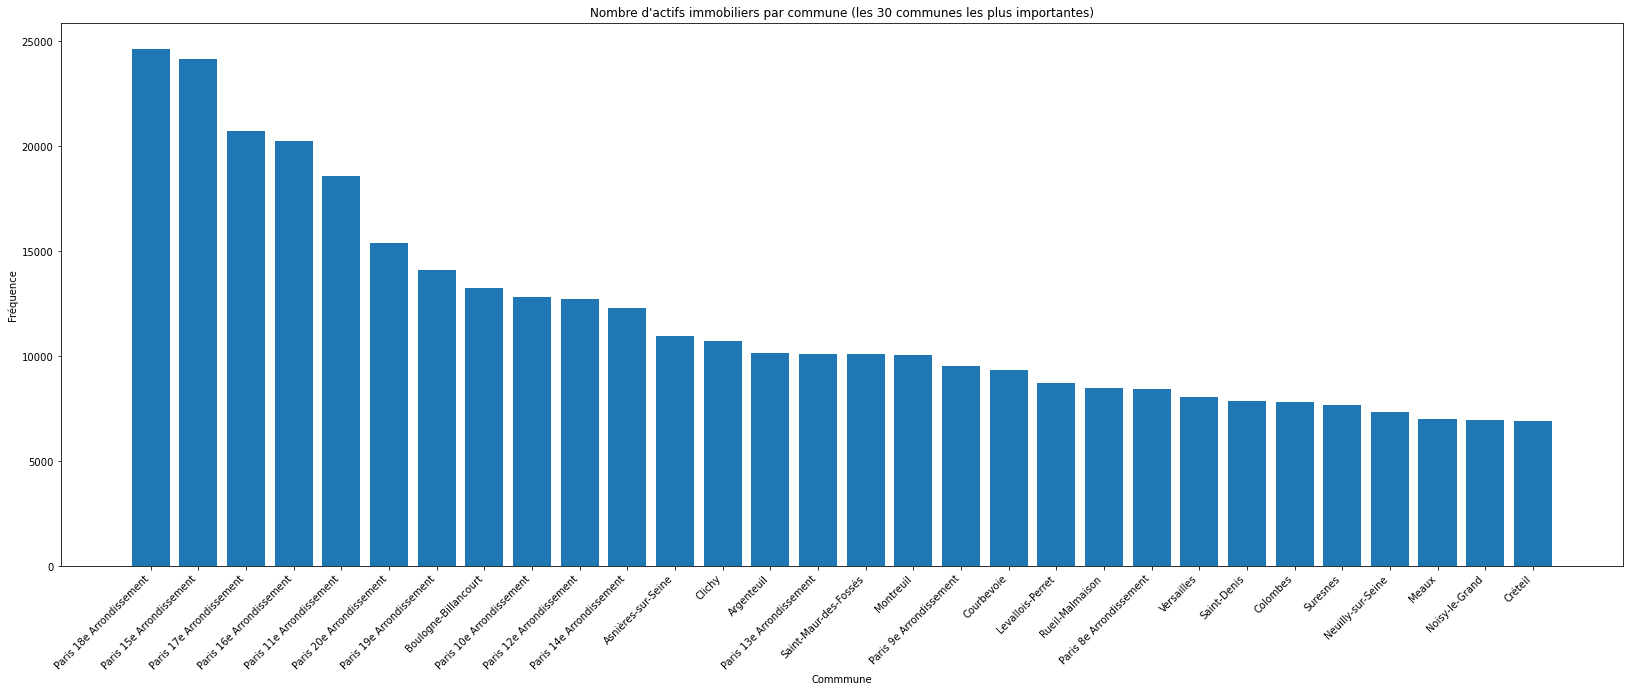

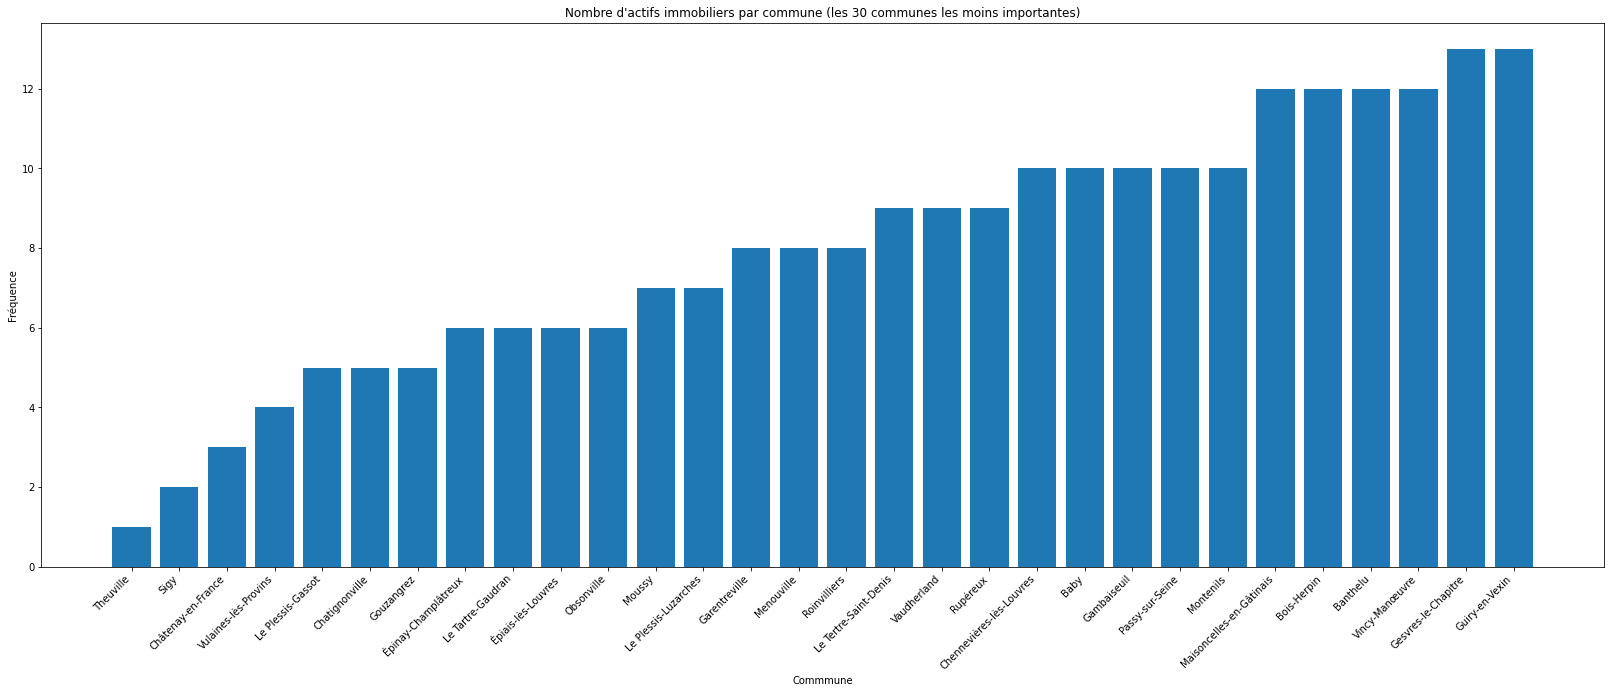

In [11]:
d = {'nom_commune' : data['nom_commune'].value_counts().index, 'frequence' : data['nom_commune'].value_counts().values}
high_freq_commune = pd.DataFrame(d)[:30]
low_freq_commune = pd.DataFrame(d).sort_values(by='frequence',ascending=True)[:30]

plt.figure(figsize=(28,10))
plt.bar(x=high_freq_commune['nom_commune'],height=high_freq_commune['frequence'],align='center')
plt.title("Nombre d'actifs immobiliers par commune (les 30 communes les plus importantes)")
plt.xlabel("Commmune")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Fréquence")
plt.show()


plt.figure(figsize=(28,10))
plt.bar(x=low_freq_commune['nom_commune'],height=low_freq_commune['frequence'],align='center')
plt.title("Nombre d'actifs immobiliers par commune (les 30 communes les moins importantes)")
plt.xlabel("Commmune")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Fréquence")
plt.show()

## Analyse du p/m2

In [12]:
intervalIndex = pd.interval_range(start=0, end=100000, freq=100)
surface_range = pd.cut(data['surface_reelle_bati'],bins=intervalIndex).astype('str').str.replace('(','').str.replace(']','')
data['interval_surface_100'] =  surface_range

#

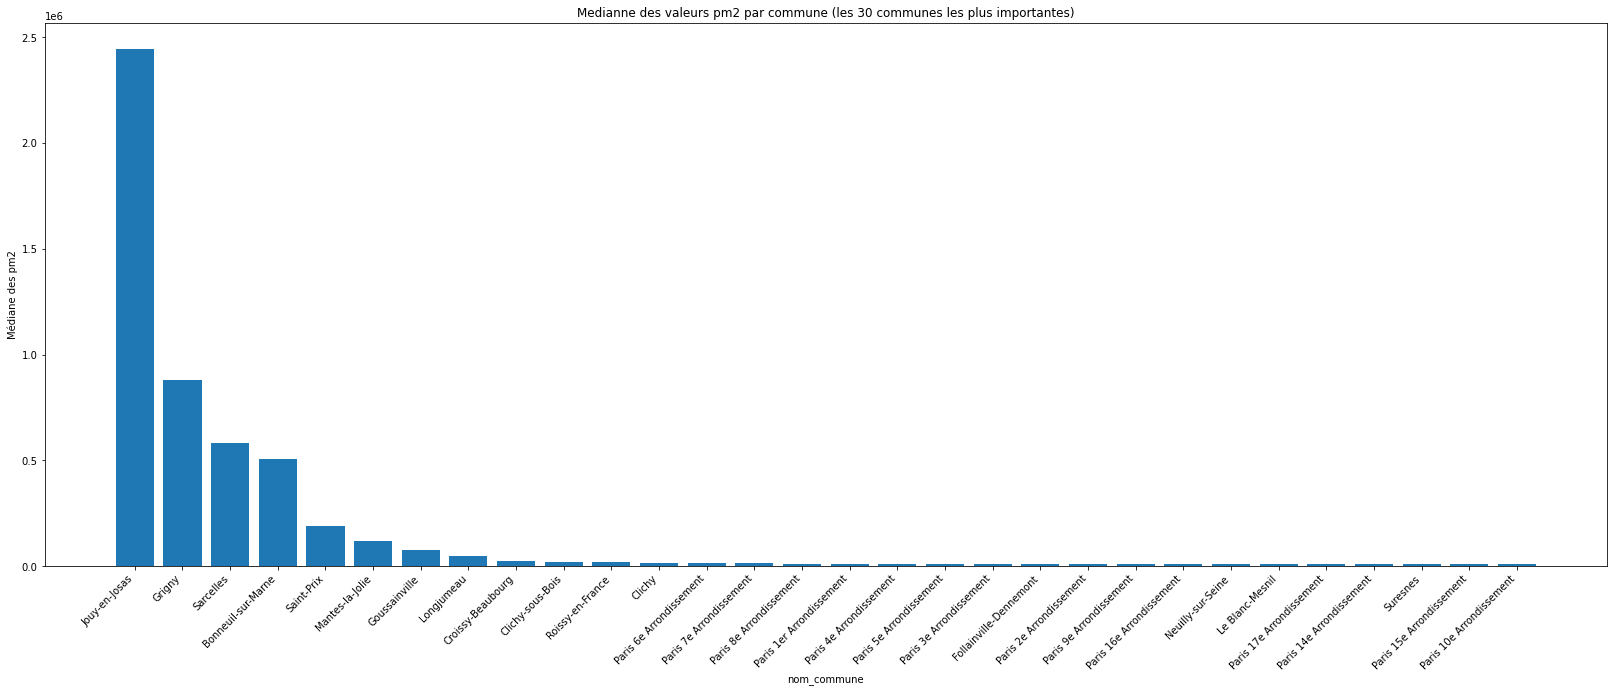

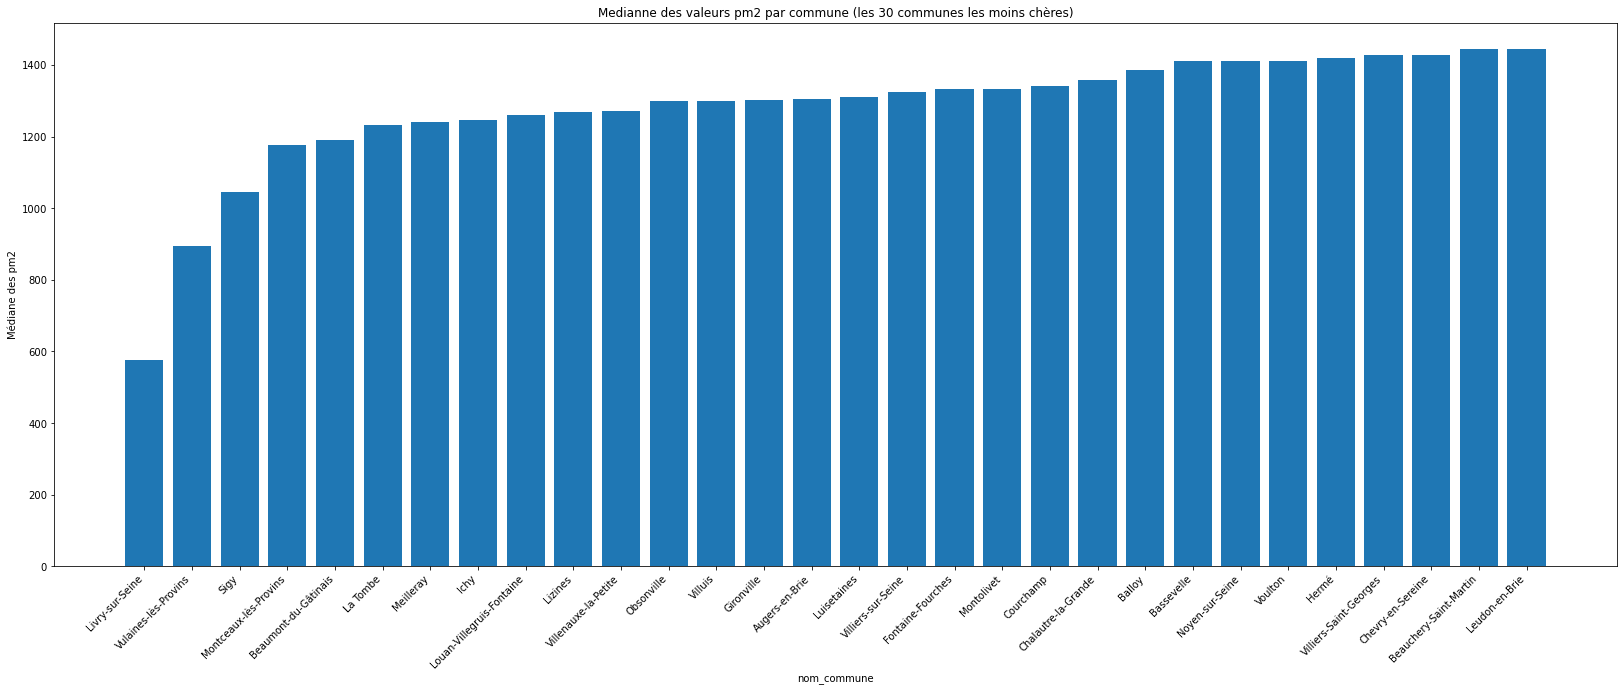

In [24]:
price_by_commune = data[['nom_commune','pm2']].groupby('nom_commune').median().sort_values(by='pm2',ascending=False)[:30]

plt.figure(figsize=(28,10))
plt.bar(x=price_by_commune.index,height=price_by_commune['pm2'],align='center')
plt.title("Medianne des valeurs pm2 par commune (les 30 communes les plus importantes)")
plt.xlabel("nom_commune")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Médiane des pm2")
plt.show()

price_by_commune_asc = data[['nom_commune','pm2']].groupby('nom_commune').median().sort_values(by='pm2',ascending=True)[:30]
plt.figure(figsize=(28,10))
plt.bar(x=price_by_commune_asc.index,height=price_by_commune_asc['pm2'],align='center')
plt.title("Medianne des valeurs pm2 par commune (les 30 communes les moins chères)")
plt.xlabel("nom_commune")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Médiane des pm2")
plt.show()

In [27]:
price_by_commune.head()

,pm2
nom_commune,
Jouy-en-Josas,2.445992e+06
Grigny,8.812623e+05
Sarcelles,5.819355e+05
Bonneuil-sur-Marne,5.048331e+05
Saint-Prix,1.896818e+05


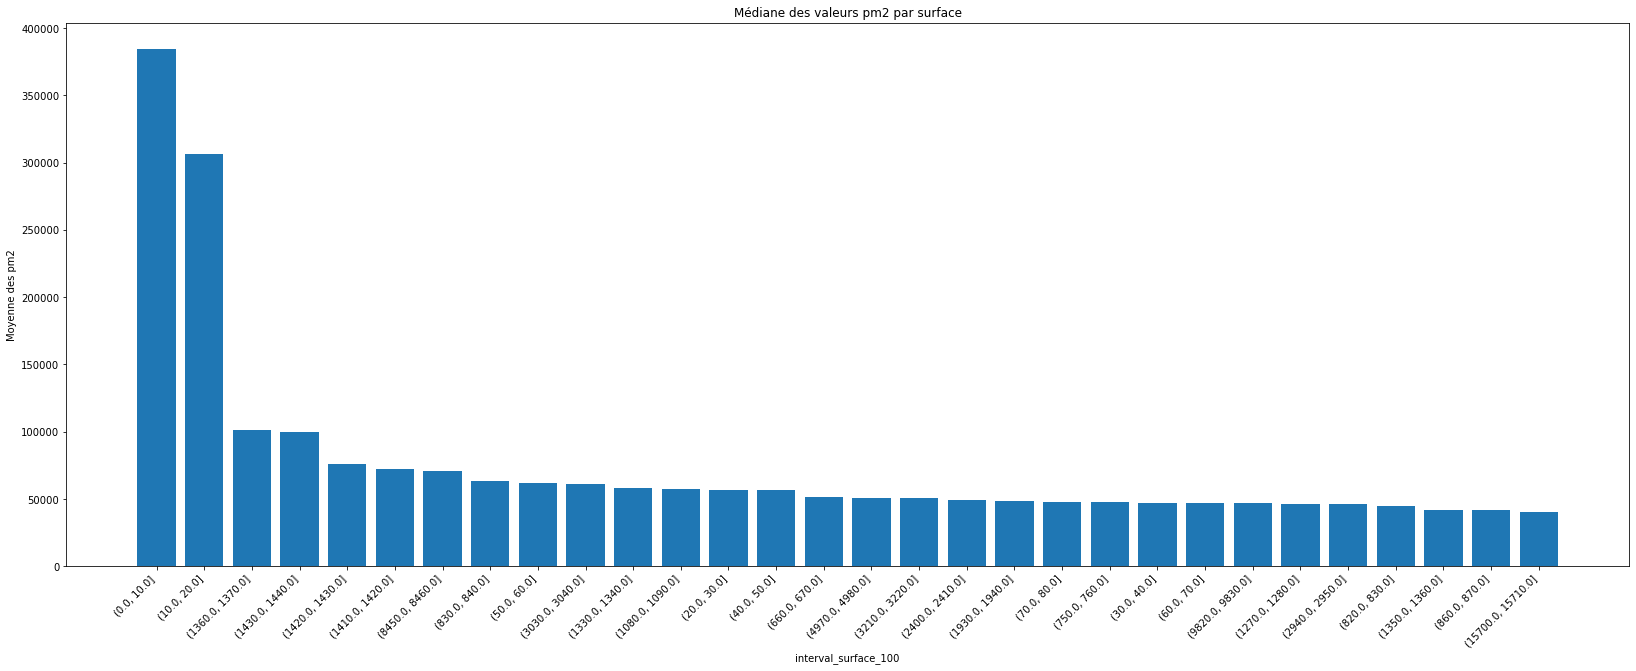

In [28]:
data['interval_surface_100'] =  surface_range
price_by_range = data[['interval_surface_100','pm2']].groupby('interval_surface_100').mean().sort_values(by='pm2',ascending=False)[:30]

plt.figure(figsize=(28,10))
plt.bar(x=price_by_range.index,height=price_by_range['pm2'],align='center')
plt.title("Médiane des valeurs pm2 par surface")
plt.xlabel("interval_surface_100")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Moyenne des pm2")
plt.show()

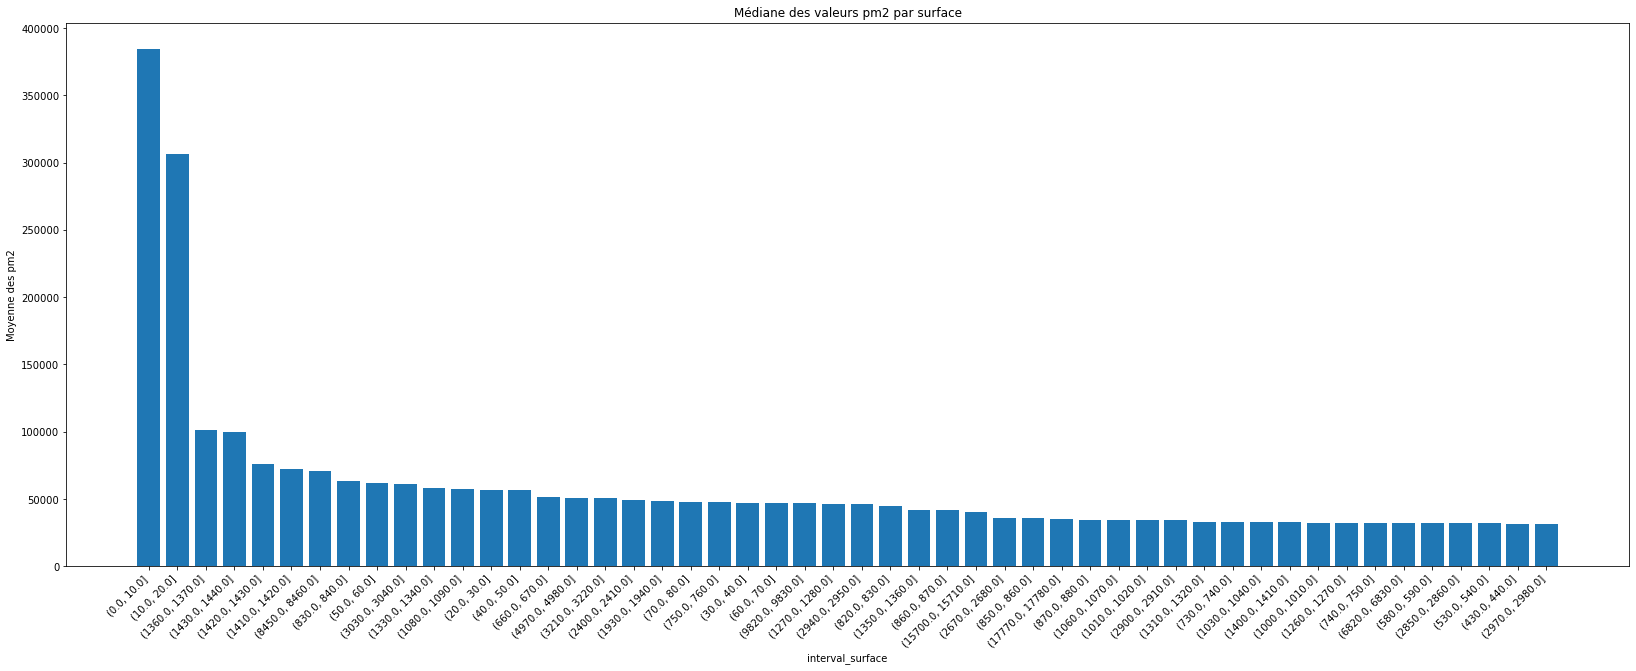

In [14]:
price_by_range = data[['interval_surface','pm2']].groupby('interval_surface').mean().sort_values(by='pm2',ascending=False)[:50]

plt.figure(figsize=(28,10))
plt.bar(x=price_by_range.index,height=price_by_range['pm2'],align='center')
plt.title("Médiane des valeurs pm2 par surface")
plt.xlabel("interval_surface")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Moyenne des pm2")
plt.show()

## Matrice de correlation 

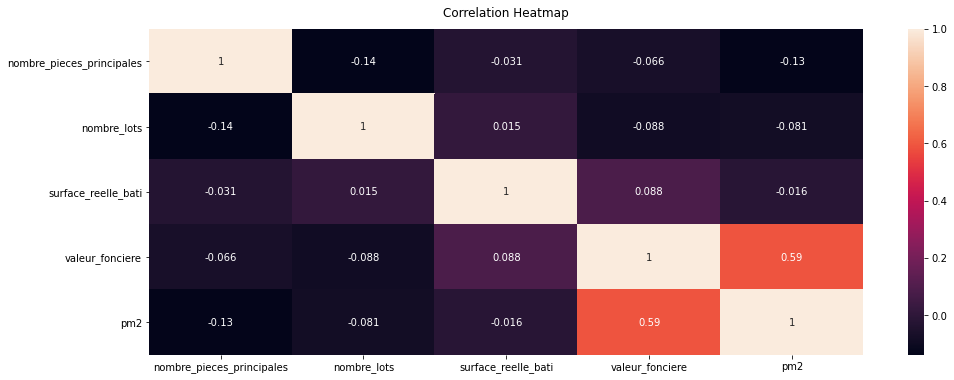

In [16]:
correlated_variables = ['nombre_pieces_principales','nombre_lots','surface_reelle_bati','valeur_fonciere','pm2']
corr = data[correlated_variables].corr()
plt.figure(figsize=(16, 6))
heatmap = sn.heatmap(corr, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

# 3 Non-supervisé

On determine le nombre de cluster optimale grace à la méthode elbow

In [30]:
scaler = StandardScaler()
features = ['nombre_pieces_principales','nombre_lots','surface_reelle_bati','valeur_fonciere','pm2']
scaler.fit(data[features])
dat_scaled = pd.DataFrame(scaler.transform(data[features]),columns=features)

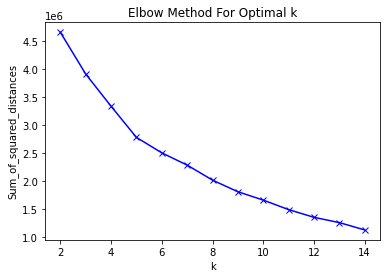

In [20]:
K = range(2,15)
km_score=[]
Sum_of_squared_distances = []
for k in K: #Pour un nombre de composant de 2 à 10
    kmeans = KMeans(n_clusters=k).fit(dat_scaled) #On instancie l'algorithme kmean avec un nombre de centroid = à i
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Interpretation : Dans le graphique ci-dessus, le coude est à k=5, ce qui indique que le nombre de cluster optimal pour cet ensemble de données est 5. Pour 5 FEATURES

In [31]:
kmeans = KMeans(n_clusters=5).fit(dat_scaled) 
data['label'] = kmeans.labels_

In [32]:
data['label'].value_counts()

2    691631
0    480658
3     27508
1       213
4       168
Name: label, dtype: int64

## 3.2. Visualisation des clusters

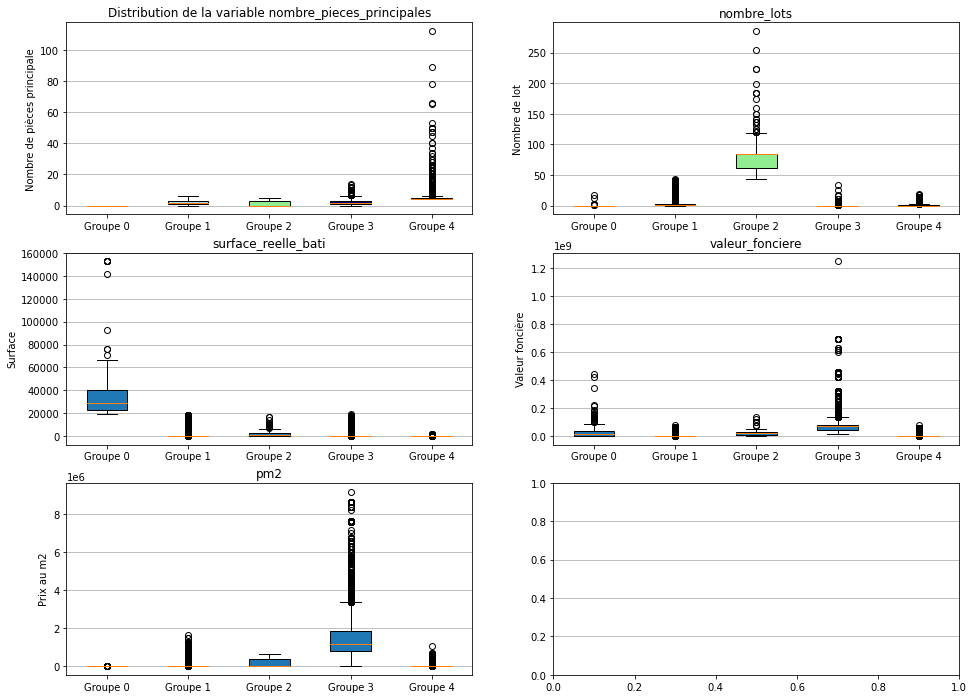

In [26]:
import matplotlib.pyplot as plt
import numpy as np
pieces = np.array([data[data.label == 0]['nombre_pieces_principales'].tolist(),
                      data[data.label == 1]['nombre_pieces_principales'].tolist(),
                      data[data.label == 2]['nombre_pieces_principales'].tolist(),
                      data[data.label == 3]['nombre_pieces_principales'].tolist(),
                      data[data.label == 4]['nombre_pieces_principales'].tolist()], dtype=object)

lots = np.array([data[data.label == 0]['nombre_lots'].tolist(),
                      data[data.label == 1]['nombre_lots'].tolist(),
                      data[data.label == 2]['nombre_lots'].tolist(),
                      data[data.label == 3]['nombre_lots'].tolist(),
                      data[data.label == 4]['nombre_lots'].tolist(),], dtype=object)

surface = np.array([data[data.label == 0]['surface_reelle_bati'].tolist(),
                      data[data.label == 1]['surface_reelle_bati'].tolist(),
                      data[data.label == 2]['surface_reelle_bati'].tolist(),
                      data[data.label == 3]['surface_reelle_bati'].tolist(),
                      data[data.label == 4]['surface_reelle_bati'].tolist()], dtype=object)

valeur = np.array([data[data.label == 0]['valeur_fonciere'].tolist(),
                      data[data.label == 1]['valeur_fonciere'].tolist(),
                      data[data.label == 2]['valeur_fonciere'].tolist(),
                      data[data.label == 3]['valeur_fonciere'].tolist(),
                      data[data.label == 4]['valeur_fonciere'].tolist()], dtype=object)

pm2 = np.array([data[data.label == 0]['pm2'].tolist(),
                      data[data.label == 1]['pm2'].tolist(),
                      data[data.label == 2]['pm2'].tolist(),
                      data[data.label == 3]['pm2'].tolist(),
                      data[data.label == 4]['pm2'].tolist()], dtype=object)


labels = ['Groupe 0', 'Groupe 1', 'Groupe 2', 'Groupe 3', 'Groupe 4']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

# box plot variable nombre_pieces_principales
bplot1 = axes[0][0].boxplot(pieces,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[0][0].set_title('Distribution de la variable nombre_pieces_principales')

# box plot of variable nombre_lots
bplot2 = axes[0][1].boxplot(lots,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[0][1].set_title('nombre_lots')


# box plot of variable surface_reelle_bati
bplot3 = axes[1][0].boxplot(surface,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[1][0].set_title('surface_reelle_bati')

# box plot of variable valeur_fonciere
bplot3 = axes[1][1].boxplot(valeur,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[1][1].set_title('valeur_fonciere')


# box plot of variable pm2
bplot3 = axes[2][0].boxplot(pm2,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[2][0].set_title('pm2')





# fill with colors
colors = ['pink', 'lightblue', 'lightgreen','navy']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    for ax_c in ax:
      ax_c.yaxis.grid(True)

axes[0][0].set_ylabel('Nombre de pièces principale')
axes[0][1].set_ylabel('Nombre de lot')
axes[1][0].set_ylabel('Surface')
axes[1][1].set_ylabel('Valeur foncière')
axes[2][0].set_ylabel('Prix au m2')


#axes[1][0].set_ylim(0, 30)
#axes[0][0].set_ylim(0, 750)
#axes[0][1].set_ylim(0, 200)

plt.show()

### Analyse des cluster

Groupe 0 : composé de 514080 mutations, correspond à des petits biens  <br/>
Groupe 1 : composé de 146 mutations, correspond à des biens de grandes valeur foncière et de grande surface <br/>
Groupe 2 : composé de 688407 mutations, correspond à des biens de grandes valeur foncière et de grande surface <br/>

# 4.  supervisé 

In [ ]:
# On construit un df par année
data_2019 = data[data['date_mutation'].str[:4] == '2019']
data_2018 = data[data['date_mutation'].str[:4] == '2018']

In [ ]:
# Les variables explicatives vont constitués la clé de regroupement pour définir un « type » 
# de bien mais pas seulement . On peut aussi filtrer sur l’adresse pour avoir une précision 
# sur la localisation du bien sans avoir à regrouper selon la latitude et la longitude
#cle = ["interval_surface","nature_mutation","nom_commune","type_local","adresse_nom_voie","nombre_pieces_principales",'nombre_lots']
cle = ["interval_surface","nature_mutation","code_commune_voie","code_type_local","code_commune","nombre_pieces_principales",'nombre_lots']

# On crée une variable « d’identification » pour regrouper et comparer les biens entre eux
data_2018["cle"] = ""
data_2019["cle"] = ""


for c in cle:    
    data_2018["cle"] += "_"+data_2018[c].astype(str)
    data_2019["cle"] += "_"+data_2019[c].astype(str)


key_2018 = data_2018["cle"].unique()
key_2019 = data_2019["cle"].unique()

from functools import reduce
common_keys = reduce(np.intersect1d, (key_2018,key_2019))

len(common_keys)

In [ ]:
# Une facon pour calculer le prix en prenant la médiane puis de matcher toutes les données
data_2019 = data_2019[data_2019["cle"].isin(common_keys)]
data_2018 = data_2018[data_2018["cle"].isin(common_keys)]

 
data_groupe_2019 = data_2019[["cle","pm2","nombre_pieces_principales",
                              "surface_reelle_bati","nombre_lots"]].groupby("cle").agg({'pm2':'median',
                                                                                        'surface_reelle_bati':'mean'})
data_groupe_2018 = data_2018[["cle","pm2","nombre_pieces_principales",
                              "surface_reelle_bati","nombre_lots"]].groupby("cle").agg({'pm2':'median',
                                                                                       'surface_reelle_bati':'mean'})

 
data_groupe_2019= data_groupe_2019.reset_index()
data_groupe_2019 = data_groupe_2019.merge(data_2019[cle+["cle"]], on="cle" )
 
data_classification = pd.DataFrame()
data_classification["pm2_before"] = data_groupe_2018["pm2"].values
data_classification["surface_reelle_bati_before"] = data_groupe_2018["surface_reelle_bati"].values

data_classification["cle"] = data_groupe_2018.index
 
data_classification = data_classification.merge(data_groupe_2019,on="cle")
 
data_classification["augmentation"] = (data_classification["pm2"]-data_classification["pm2_before"])>0
data_classification['variation_pm2'] = (data_classification['pm2'] - data_classification['pm2_before'])/data_classification['pm2']
data_classification['variation_surface'] = (data_classification['surface_reelle_bati'] - data_classification['surface_reelle_bati_before'])/data_classification['surface_reelle_bati']


print("Shape : ", data_classification.shape)
data_classification.head(3)

In [ ]:
pd.DataFrame(data_classification['augmentation'].value_counts())

## 4.2 Data Prep : Filtre sur les adresses les plus fréquentes

On selectionnes les 50 Rues/Voies avec le plus d'actifs immobilier à vendre
Au départ il y avait 13798 adresses

In [ ]:
nb_voies_max = 750

In [ ]:
d = {'code_commune_voie' : data_classification['code_commune_voie'].value_counts().index, 'frequence' : data_classification['code_commune_voie'].value_counts().values}
freq_adresses = pd.DataFrame(d)[:nb_voies_max]
print('frequence min : ', freq_adresses['frequence'].min())
freq_adresses.head()

In [ ]:
dataset = data_classification[data_classification.code_commune_voie.isin(freq_adresses.code_commune_voie)]
dataset.reset_index(inplace=True)
print('dataset before filtering : ', data_classification.shape)
print('dataset after filtering on ', nb_voies_max, ' most frequent adress: ', dataset.shape)
print('number of commune after filtering :', len(dataset['code_commune'].unique()))

## 4.3. Encodage des variables categorielle 

In [ ]:
var_num = ['nombre_pieces_principales','nombre_lots',
              'surface_reelle_bati','variation_surface','pm2_before']

var_cat = ['code_commune','nature_mutation','code_type_local','code_commune_voie']

In [ ]:
X_dum = pd.get_dummies(dataset[var_cat])
print('X_dum shape : ', X_dum.shape)
X_dum.head()

## 4.4 Normalisation des variables numériques

In [ ]:
scaler = MinMaxScaler()
scaler.fit(dataset[var_num])
X = pd.DataFrame(scaler.transform(dataset[var_num]),columns=var_num)
X = X.merge(X_dum, left_index=True,right_index=True)
X.head()
#X = dataset

## 4.5. Séparation des données

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, dataset['augmentation'], test_size=0.33, random_state=42)
print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)

## 4.6. Entrainement du modèle d'arbre de décision

In [ ]:
# créer un estimateur
estimator = DecisionTreeClassifier()
# entrainer l'estimateur
clf=estimator.fit(X_train, y_train)

### Importance des variables

In [ ]:
variables_importance = pd.DataFrame(data = {'variable':X.columns,
                     'importance' : clf.feature_importances_}).sort_values(by='importance', ascending=False)
variables_importance.reset_index(inplace=True)
variables_importance.head(15)

In [ ]:
data[data.code_commune_voie == '92024_9640'][['nom_commune','adresse_nom_voie']].head(1)

## 4.7. Scoring

Score : précision moyenne

score on validation data

In [ ]:
print("Score on train data : " ,clf.score(X_train,y_train))
print("Score on validation data : " ,clf.score(X_test,y_test))

# 4. Régression linéaire avec Lasso

Étant données le nombre considérable de variables associés à code de l'adresse, on utilise la technique de régularisation lasso afin de réduire le nombre de prédicteur.

## 4.1. Prépatation des données

On entraine un modèle Lasso avec différentes valeur de alpha : [1, 0,01, 0.001, 0,0001, 0,00005] <br/>
On effectue une technique  cross validation pour tester nos modèles

In [ ]:
var_num_r = ['nombre_pieces_principales','nombre_lots',
              'surface_reelle_bati_log','variation_surface','pm2_before_log']

var_cat_r = ['code_commune_voie','nature_mutation','code_type_local']

In [ ]:
# filtre
nb_voies_max_reg = 5000

d = {'code_commune_voie' : data_classification['code_commune_voie'].value_counts().index, 'frequence' : data_classification['code_commune_voie'].value_counts().values}
freq_adresses = pd.DataFrame(d)[:nb_voies_max_reg]
print('freq adresse min : ', freq_adresses.frequence.min())

data_reg = data_classification[(data_classification.code_commune_voie.isin(freq_adresses.code_commune_voie))]
data_reg['pm2_before_log'] = np.log(data_reg['pm2_before'])
data_reg['surface_reelle_bati_log'] = np.log(data_reg['surface_reelle_bati'])

X_dum_reg = pd.get_dummies(data_reg[var_cat_r])
X_reg = data_reg[var_num_r].merge(X_dum_reg, left_index=True,right_index=True)
y_reg = np.log(data_reg['pm2'])
print('nombre de prédicteurs : ', X_reg.shape[1])
print('Taille de l\'échantillons : ', X_reg.shape[0])
#
#
#

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_reg,y_reg, test_size=0.3, random_state=31)

In [ ]:
lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)

print ("training score:", train_score)
print ("test score: ", test_score)
print ("number of features used: for alpha= 1.0 (Default): ", coeff_used)

In [ ]:
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("training score for alpha=0.01:", train_score001)
print ("test score for alpha =0.01: ", test_score001)
print ("number of features used: for alpha =0.01:", coeff_used001)

In [ ]:
lasso0001 = Lasso(alpha=0.001, max_iter=10e5)
lasso0001.fit(X_train,y_train)
train_score0001=lasso0001.score(X_train,y_train)
test_score0001=lasso0001.score(X_test,y_test)
coeff_used0001 = np.sum(lasso0001.coef_!=0)
print ("training score for alpha=0.001:", train_score0001)
print ("test score for alpha =0.001: ", test_score0001)
print ("number of features used: for alpha =0.001:", coeff_used0001)

In [ ]:
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print ("training score for alpha=0.0001:", train_score00001)
print ("test score for alpha =0.0001: ", test_score00001)
print ("number of features used: for alpha =0.0001:", coeff_used00001)

In [ ]:
lasso000005 = Lasso(alpha=0.00005, max_iter=10e5)
lasso000005.fit(X_train,y_train)
train_score000005=lasso000005.score(X_train,y_train)
test_score000005=lasso000005.score(X_test,y_test)
coeff_used000005 = np.sum(lasso000005.coef_!=0)
print ("training score for alpha=0.00005:", train_score000005)
print ("test score for alpha =0.00005: ", test_score000005)
print ("number of features used: for alpha =0.00005:", coeff_used000005)

In [ ]:
lasso0000001 = Lasso(alpha=0.000001, max_iter=10e5)
lasso0000001.fit(X_train,y_train)
train_score0000001=lasso0000001.score(X_train,y_train)
test_score0000001=lasso0000001.score(X_test,y_test)
coeff_used0000001 = np.sum(lasso0000001.coef_!=0)
print ("training score for alpha=0.0000001:", train_score0000001)
print ("test score for alpha =0.0000001: ", test_score0000001)
print ("number of features used: for alpha =0.0000001:", coeff_used0000001)

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)
print ("LR training score:", lr_train_score)
print ("LR test score: ", lr_test_score)

## 4.2. Résultats et choix du modèle

In [ ]:
scores001 = cross_val_score(lasso001, X_reg, y_reg, cv=10)
print('cross validation score for alpha=0,01:', scores001.mean())
scores0001 = cross_val_score(lasso0001, X_reg, y_reg, cv=10)
print('cross validation score for alpha=0,001:', scores0001.mean())
scores00001 = cross_val_score(lasso00001, X_reg, y_reg, cv=10)
print('cross validation score  for alpha =0.0001:', scores00001.mean())
scores000005 = cross_val_score(lasso000005, X_reg, y_reg, cv=10)
print('cross validation score for alpha =0.00005 :', scores000005.mean())
scores0000001 = cross_val_score(lasso0000001, X_reg, y_reg, cv=10)
print('cross validation score for alpha =0.0000001 :', scores0000001.mean())

En procédant à une régression lineaire simple, on obtient un R-score négatif, ce qui signifie que notre est modèle est sur-entrainer, il n'est pas en mesure de faire des prédiction fiables sur des nouvelles données.<br/>
On obtient un R-score de 0,644 avec une valeur du coefficient alpha de 0.644. On préfère ce modèle à celui avec un coefficient alpha e 0,0000001 car il utilise moins de variables même si son score est légerement plus faible. le modèle associé à cette valeur est utilise 953 variables<br/>
Notre échantillon contient 5012 variables et 54977 lignes

| Alpha | R-score cross-validation | Nombre de variables utilisées
| --- | --- | --- |
| 0.01 | 0.539 |  6 |
| 0.001 | 0.584 | 34|
| 0.0001 | 0.638 | 388|
| 0.00005 | 0.644 | 953|
| 0.000001 | 0.648 | 4876|